In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from copy import deepcopy
from torch.optim.lr_scheduler import StepLR
from mpl_toolkits.mplot3d import Axes3D

NUM_STEPS = 100
def gaussian_mixture_sample(batch_size, num_coords=1, x1=-1.5, x2=1.5):
    """Sample from a mixture of two Gaussians centered at x1 and x2"""
    component = torch.randint(0, 2, (batch_size,)).repeat(num_coords, 1)
    
    mean = torch.where(component.T == 0, x1, x2)
    return mean + torch.randn(batch_size, num_coords)


def sigma(t):
    beta_t = 1 - t
    alpha_t = t
    alpha_t_dot = 1  # Derivative of alpha_t = 1
    beta_t_dot = -1  # Derivative of beta_t = -1
    return torch.sqrt(2 * beta_t * ((alpha_t_dot / alpha_t) * beta_t - beta_t_dot))

def plot_3d_distributions():
    x_vals = np.linspace(-5, 5, 100)
    y_vals = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x_vals, y_vals)
    grid = np.stack([X.ravel(), Y.ravel()], axis=-1)
    mean1 = np.array([0, 0])
    cov1 = np.eye(2)
    pdf1 = gaussian_pdf(grid, mean1, cov1).reshape(100, 100)
    
    mean2a = np.array([-1.5, -1.5])
    mean2b = np.array([1.5, 1.5])
    cov2 = np.eye(2)
    pdf2a = gaussian_pdf(grid, mean2a, cov2).reshape(100, 100)
    pdf2b = gaussian_pdf(grid, mean2b, cov2).reshape(100, 100)
    pdf2 = 0.5 * (pdf2a + pdf2b)
    
    pdf3 = pdf2 * np.exp(np.sin(X))
    pdf3 /= np.trapz(np.trapz(pdf3, x_vals, axis=0), y_vals, axis=0)
    
    fig = plt.figure(figsize=(15, 5))
    
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(X, Y, pdf1, cmap='viridis', alpha=0.7)
    ax1.set_title('Gaussian N(0, I)')
    
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(X, Y, pdf2, cmap='plasma', alpha=0.7)
    ax2.set_title('Gaussian Mixture')
    
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.plot_surface(X, Y, pdf3, cmap='inferno', alpha=0.7)
    ax3.set_title('Gaussian Mixture * $e^{(sin(x1))}$')
    
    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Probability Density')

    plt.show()

def gaussian_pdf(X, mean, cov):
    d = X.shape[-1]
    det_cov = np.linalg.det(cov)
    norm_const = 1.0 / (np.sqrt((2 * np.pi) ** d * det_cov))
    exp_component = -0.5 * np.sum((X - mean) @ np.linalg.inv(cov) * (X - mean), axis=-1)
    return norm_const * np.exp(exp_component)

class VectorField(nn.Module):
    """Neural network modeling the continuous-time velocity field."""
    def __init__(self, n_coords):
        self.n_coords = n_coords
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(self.n_coords + 1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, self.n_coords)
        )
    
    def forward(self, x, t):
        xt = torch.cat([x, t], dim=1)
        return self.net(xt)

def plot_3d_histogram(samples, x_vals, y_vals):
    hist, x_edges, y_edges = np.histogram2d(samples[:, 0], samples[:, 1], bins=[x_vals, y_vals], density=True)
    X, Y = np.meshgrid(x_edges[:-1], y_edges[:-1])
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, hist.T, cmap='inferno', alpha=0.8)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Density')
    ax.set_title('3D Histogram of Samples')
    plt.show()
    
def train_flow_matching(num_steps=NUM_STEPS, n_coords=1, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VectorField(n_coords).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    losses = []
    for step in tqdm(range(num_steps), desc="Training Progress"):
        x0 = torch.randn(batch_size, n_coords).to(device) * 0.1  # Samples from initial Gaussian
        x1 = gaussian_mixture_sample(batch_size, n_coords, x1=torch.Tensor([-1.5, -1.5]), x2=torch.Tensor([1.5, 1.5])).view(-1, n_coords).to(device)  # Target distribution
        t = torch.rand(batch_size, 1).to(device)  # Uniformly sampled time
        xt = (1 - t) * x0 + t * x1  # Linear interpolation
        v_target = x1 - x0  # Target velocity field
        v_pred = model(xt, t)  # Predicted velocity
        loss = ((v_pred - v_target) ** 2).mean()  # Mean squared error
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step % (num_steps // 4) == 0:
            print(f"Step {step}: Loss = {loss.item():.6f}")
            # plot_intermediate_distribution(model)
        losses.append(loss.item())
    plot_intermediate_distribution(model, n_coords)
    return model, losses

def sample_from_flow(model, num_samples=5000, num_coords=1, num_steps=NUM_STEPS, traj=False):
    """Simulate flow dynamics to generate samples."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    x = torch.randn(num_samples, num_coords).to(device) * 0.1
    dt = 1.0 / num_steps
    trajec = torch.zeros((num_samples, num_steps, num_coords))
    for i in range(num_steps):
        t = torch.full((num_samples,), i / num_steps, device=device).view(-1, 1)
        v = model(x, t)
        x = x + v * dt  # Euler integration
        if traj:
            trajec[:, i, :] = x

    if traj:
        return trajec.cpu().detach().numpy()
    return x.cpu().detach().numpy()


def plot_intermediate_distribution(model, n_coords, num_samples=100000):
    """Plot the intermediate learned distribution."""
    samples = sample_from_flow(model, num_samples=num_samples, num_coords=n_coords)
    if n_coords == 1:
        plt.hist(samples, bins=30, density=True, alpha=0.7, label='Flow Samples')
        x_vals = np.linspace(-5, 5, 1000)
        pdf = 0.5 * np.exp(-0.5 * (x_vals + 1.5) ** 2) / np.sqrt(2 * np.pi) + \
              0.5 * np.exp(-0.5 * (x_vals - 1.5) ** 2) / np.sqrt(2 * np.pi)
    
        pdf2 = pdf * np.exp(np.sin(x_vals))
        pdf2 = pdf2 / np.trapz(pdf2, x_vals)
        pdf3 = np.exp(-0.5 * (x_vals) ** 2) / np.sqrt(2 * np.pi)
        plt.plot(x_vals, pdf3, label='Source Distribution', color='green')
    
        plt.plot(x_vals, pdf, label='Target Distribution -- flow matching', color='black')
        plt.plot(x_vals, pdf2, label='Target Distribution -- adjoint matching', color='red')
        plt.legend()
        plt.show()
    if n_coords == 2:
        x_vals = np.linspace(-5, 5, 30)  
        y_vals = np.linspace(-5, 5, 30)
        plot_3d_histogram(samples, x_vals, y_vals)
        plot_3d_distributions()


def stochastic_trajectory(flow_model, batch_size, n_coords, sigma_t, device, timesteps=NUM_STEPS):
    """Simulate trajectory using memoryless noise schedule with alpha_t = t and beta_t = 1 - t."""
    dt = torch.tensor(1.0 / timesteps, requires_grad=True)
    trajectory = torch.zeros(batch_size, timesteps + 1, n_coords, device=device)
    
    trajectory[:, 0, :] = torch.randn(batch_size, n_coords).to(device) * 0.1  # Samples from initial Gaussian
    x_t = trajectory[:, 0, :]
    for t in range(1, timesteps+1):
        alpha_t = t / timesteps
        alpha_prime = 1
        t_val = (t * dt) * torch.ones_like(x_t[:, 0], device=device).view(-1, 1)
        drift = 2 * flow_model(x_t, t_val) - (alpha_prime / alpha_t) * x_t
        diffusion = sigma_t[t-1] * torch.randn_like(x_t)
        x_t = x_t + dt * drift + torch.sqrt(dt) * diffusion
        trajectory[:, t, :] = x_t.detach()

    # plt.plot(trajectory[1, :, 0].cpu().detach().numpy())
    # plt.show()
    # trajectory = torch.stack(trajectory)
    
    return trajectory


def lean_adjoint_ode(X, v_base, device, timesteps=NUM_STEPS):
    dt = 1.0 / timesteps
    a_t = torch.zeros_like(X)
    a_t[:, -1, :] = -1 * reward_grad(X[:, -1, :])
    for t in range(timesteps - 1, 0, -1):
        alpha_t = t / timesteps
        beta_t = 1 - (t / timesteps)
        alpha_t_dot = 1
        beta_t_dot = -1
        t_val = (t / timesteps) * torch.ones_like(X[:, t, 0], device=device, requires_grad=True).view(-1, 1)
        xgrad = X[:, t, :].requires_grad_(True)
        grad_input = lambda xi: 2 * v_base(xi, t_val[0].view(1,1)) - (alpha_t_dot / alpha_t) * xi
        grad_v_base = torch.stack([torch.autograd.functional.jacobian(grad_input, xgrad[i].view(1, -1)).squeeze() for i in range(xgrad.shape[0])])
        a_t[:, t, :] = (a_t[:, t + 1, :] + dt * torch.bmm(a_t[:, t + 1, :].view(a_t.shape[0], 1, a_t.shape[2]), grad_v_base).squeeze()).detach()
    return a_t

def fine_tune_flow_matching(v_base, num_steps=1000, num_coords=1, batch_size=32):
    v_finetune = deepcopy(v_base)  # Initialize with base model

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optimizer = optim.Adam(v_finetune.parameters(), lr=1e-3)
    losses = []
    for n in tqdm(range(num_steps)):
        sigma_t = sigma(torch.linspace(1 / NUM_STEPS, 1, NUM_STEPS))
        X = stochastic_trajectory(v_finetune, batch_size, num_coords, sigma_t, device=device) 
        a_t = lean_adjoint_ode(X, v_base, device)
        loss = adjoint_matching_loss(X, v_finetune, v_base, a_t, sigma_t, device)
        losses.append(loss.item())
        # torch.nn.utils.clip_grad_norm_(v_finetune.parameters(), 1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if not n % (num_steps // 4):
            print(f"Step {n}: Loss = {loss.item():.1f}")
            plot_intermediate_distribution(v_finetune, 2)
    return v_finetune, losses

def adjoint_matching_loss(X, v_finetune, v_base, a_t, sigma_t, device, timesteps=NUM_STEPS):
    loss = 0
    for t in range(1, X.shape[1]-1):
        t_val = (t / timesteps) * torch.ones_like(X[:, t, 0], device=device, requires_grad=True).view(-1, 1)
        diff = v_finetune(X[:, t, :], t_val) - v_base(X[:, t, :], t_val)
        loss += torch.sum(torch.norm((2 / sigma_t[t-1]) * diff + sigma_t[t-1] * a_t[:, t, :], dim=1) ** 2)
    return loss

def reward(x):
    return torch.sin(x[:, 0]).view(-1, 1)

def reward_grad(x):
    return torch.cos(x[:, 0]).view(-1, 1)

Training Progress:   7%|██▉                                       | 141/2000 [00:00<00:03, 476.63it/s]

Step 0: Loss = 3.498287


Training Progress:  34%|█████████████▊                           | 675/2000 [00:00<00:01, 1175.61it/s]

Step 500: Loss = 0.219038


Training Progress:  61%|████████████████████████▌               | 1227/2000 [00:01<00:00, 1251.29it/s]

Step 1000: Loss = 0.121925


Training Progress:  83%|█████████████████████████████████       | 1656/2000 [00:01<00:00, 1361.65it/s]

Step 1500: Loss = 0.200873


Training Progress: 100%|████████████████████████████████████████| 2000/2000 [00:01<00:00, 1142.67it/s]


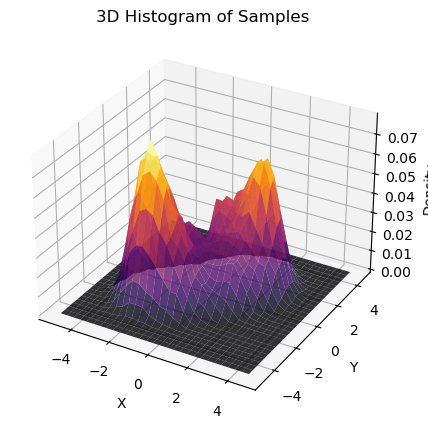

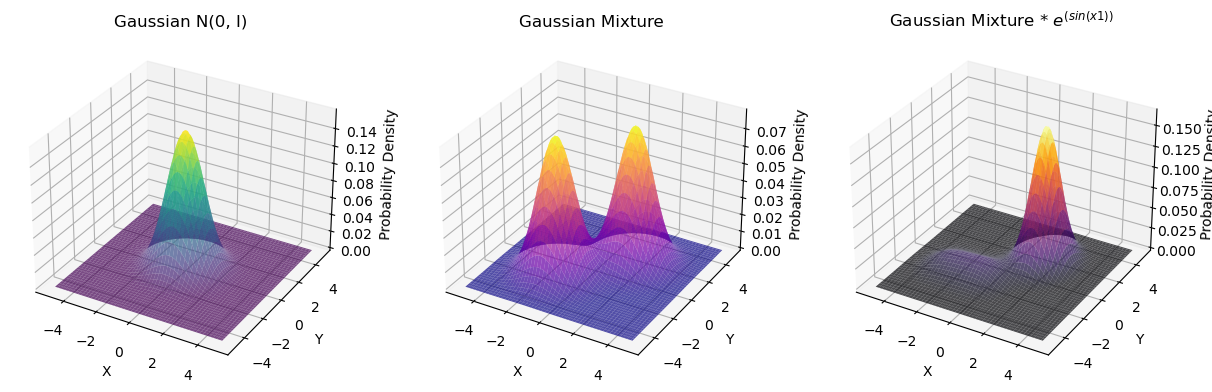

In [4]:
# Train the model
model, losses_base = train_flow_matching(2000, 2)

  0%|                                                                         | 0/250 [00:00<?, ?it/s]

Step 0: Loss = 65532.5


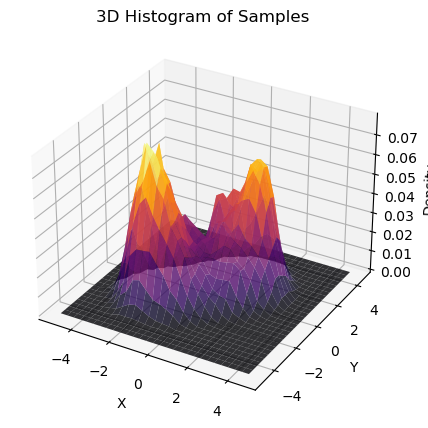

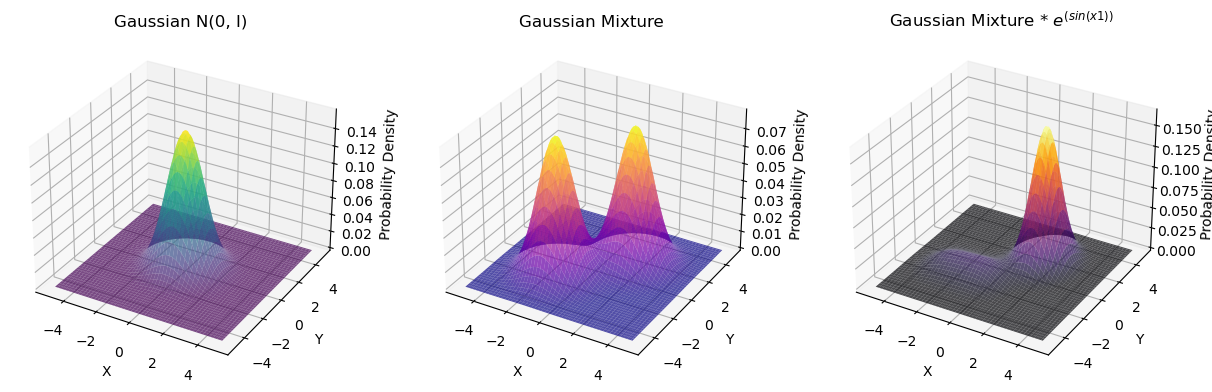

 25%|███████████████▊                                                | 62/250 [01:14<03:42,  1.18s/it]

Step 62: Loss = 92084.1


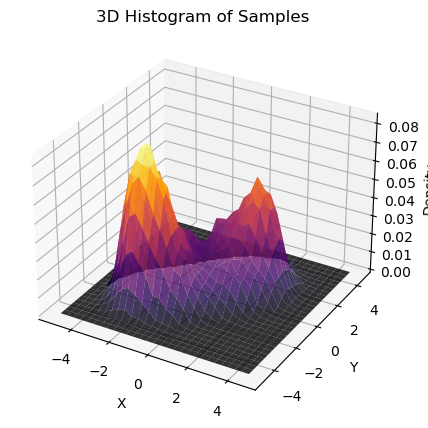

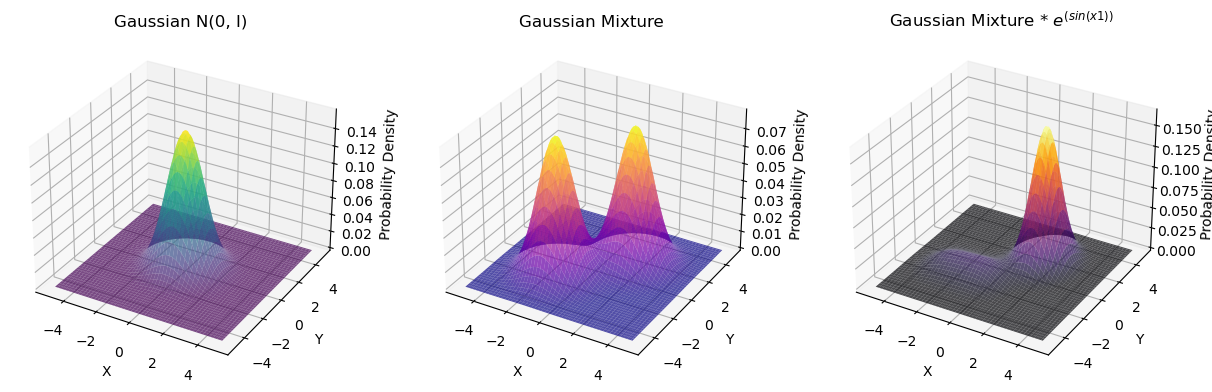

 50%|███████████████████████████████▏                               | 124/250 [02:30<02:34,  1.22s/it]

Step 124: Loss = 106373.8


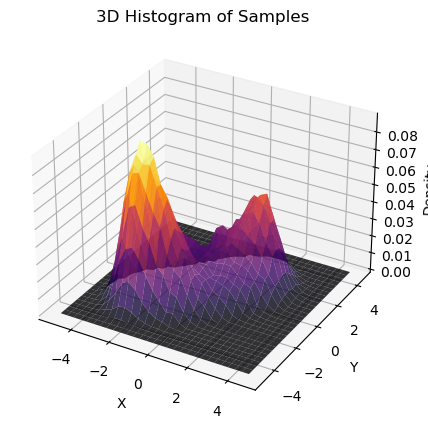

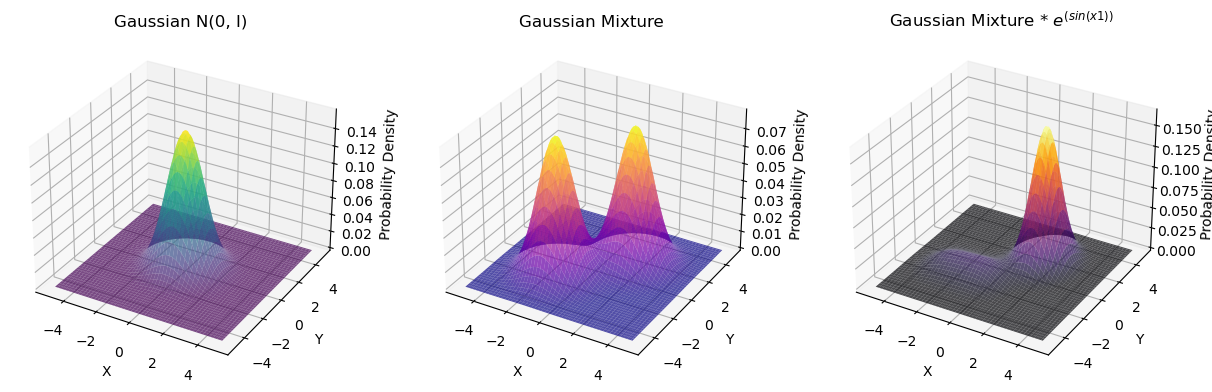

 74%|██████████████████████████████████████████████▊                | 186/250 [03:46<01:16,  1.19s/it]

Step 186: Loss = 98107.5


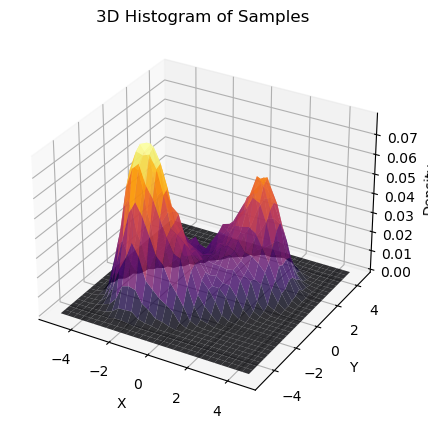

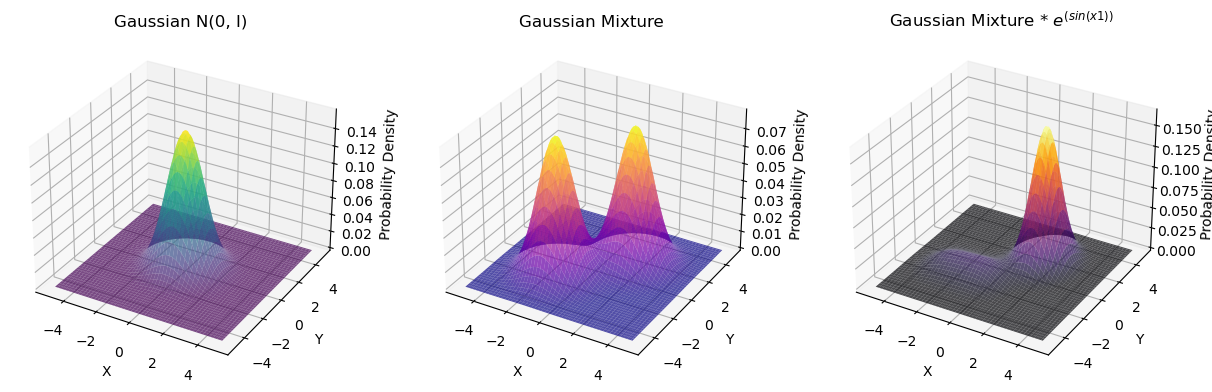

 99%|██████████████████████████████████████████████████████████████▍| 248/250 [05:01<00:02,  1.17s/it]

Step 248: Loss = 92677.2


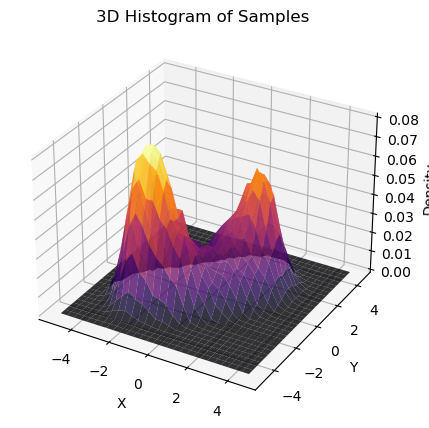

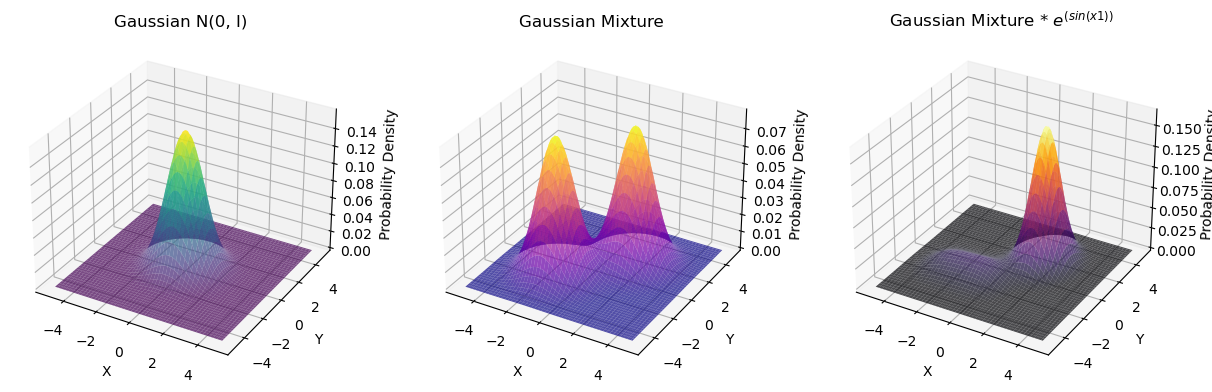

100%|███████████████████████████████████████████████████████████████| 250/250 [05:05<00:00,  1.22s/it]


In [6]:
# Sample from the trained flow
model_ft, losses = fine_tune_flow_matching(model, num_steps=250, num_coords=2)

In [ ]:
# Plot final results
plt.plot(losses_base)

In [ ]:
plot_intermediate_distribution(model_ft, 2)

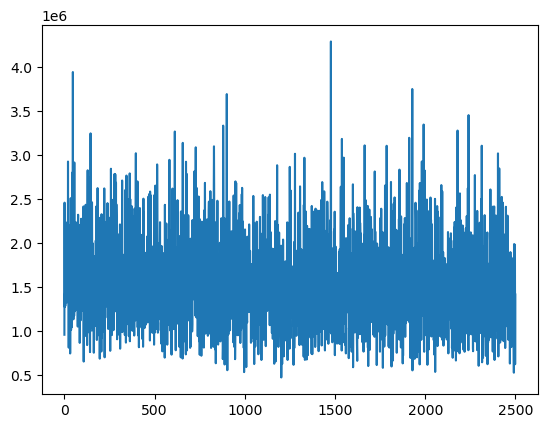

In [142]:
plt.plot(losses)

In [63]:
traj = sample_from_flow(model, num_samples=10, num_coords=2, traj=True)

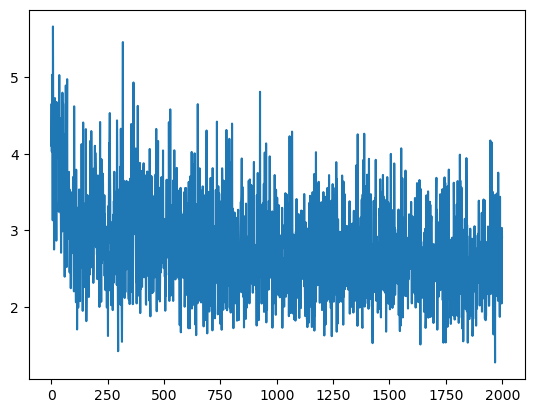

In [120]:
plt.plot(losses_base)

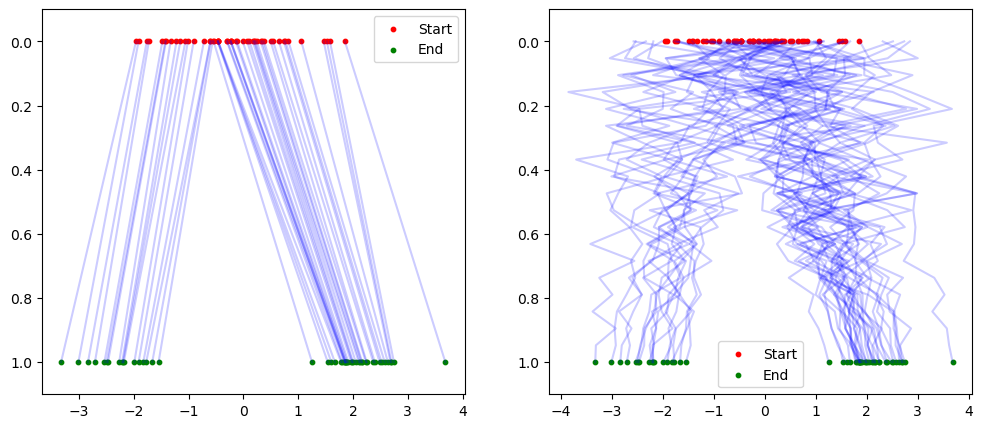

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Generate initial Gaussian samples
np.random.seed(42)
num_samples = 50
mean_initial = 0
std_initial = 1
initial_samples = np.random.normal(mean_initial, std_initial, num_samples)
initial_samples = np.sort(initial_samples)

# Define Gaussian mixture parameters
means_final = [2, -2]
stds_final = [0.5, 0.5]

# Assign samples randomly to components in the Gaussian mixture
assignments = np.random.choice(len(means_final), num_samples)
final_samples = np.array([np.random.normal(means_final[a], stds_final[a]) for a in assignments])
final_samples = np.sort(final_samples)

# Create time steps for interpolation
num_steps = 20
time_grid = np.linspace(0, 1, num_steps)

# Compute flow matching trajectories (linear interpolation for simplicity)
trajectories_fm = [(1 - t) * initial_samples + t * final_samples for t in time_grid]

# Compute memoryless adjoint matching (alternative transformation)
trajectories_mam = [(1 - t) * initial_samples + t * final_samples + np.random.normal(0, 1-t, len(initial_samples)) for t in time_grid]

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for traj in np.array(trajectories_fm).T:
    axes[0].plot(traj, np.linspace(0, 1, len(traj)), alpha=0.2, color='blue')
axes[0].scatter(initial_samples, np.zeros_like(initial_samples), s=10, color='red', label='Start')
axes[0].scatter(final_samples, np.ones_like(final_samples), s=10, color='green', label='End')
# axes[0].set_title('Flow Matching Trajectory', fontsize=14)
axes[0].legend()
axes[0].set_ylim(1.1, -0.1)

for traj in np.array(trajectories_mam).T:
    axes[1].plot(traj, np.linspace(0, 1, len(traj)), alpha=0.2, color='blue')
axes[1].scatter(initial_samples, np.zeros_like(initial_samples), s=10, color='red', label='Start')
axes[1].scatter(final_samples, np.ones_like(final_samples), s=10, color='green', label='End')
# axes[1].set_title('Memoryless Trajectory', fontsize=14)
axes[1].set_ylim(1.1, -0.1)
axes[1].legend()

plt.show()


Text(0.5, 0, '$r(x) = K - \\lambda U(x)$')

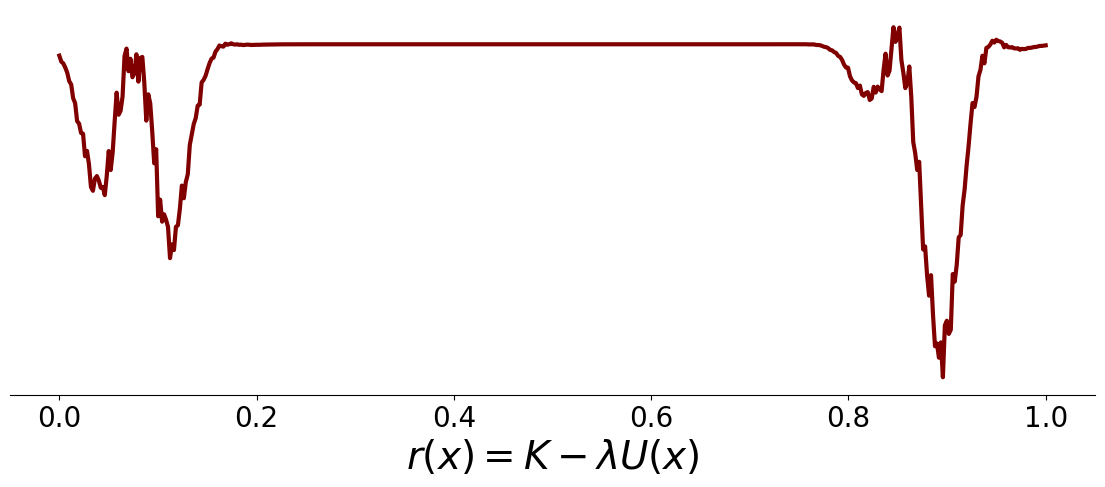

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def rugged_peaked_function(x):
    # Two Gaussian peaks centered at 0.12 and 0.78
    peak1 = np.exp(-400 * (x - 0.08)**2)  
    peak2 = np.exp(-400 * (x - 0.88)**2)

    # Rugged oscillations inside the peaks
    noise1 = peak1 * (1 * np.sin(20 * np.pi * x) + 0.2 * np.random.uniform(-1, 1, size=x.shape))
    noise2 = peak2 * (1 * np.cos(20 * np.pi * x) + 0.2 * np.random.uniform(-1, 1, size=x.shape))

    return 10 - (peak1 + peak2 + noise1 + noise2)

# Generate and plot the function
plt.figure(figsize=[14, 5])
x = np.linspace(0, 1, 500)
y = rugged_peaked_function(x)
plt.gca().axes.yaxis.set_visible(False)  # Hide y-axis
plt.gca().spines["left"].set_visible(False)  # Hide left spine
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.xticks(fontsize=20)
plt.plot(x, y, label="Rugged Peaked Function", lw=3, color="maroon")
plt.xlabel('$r(x) = K - \lambda U(x)$', fontsize=28)